# Shell Net Cash Flow Forecasting

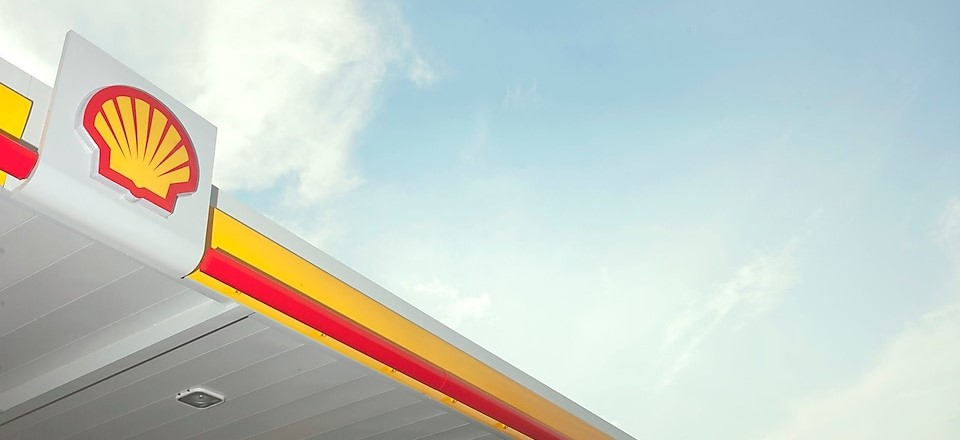

Once upon a time, in the early 20th century, a visionary entrepreneur named Marcus Samuel had a dream. He believed that the world's energy needs could be met through oil exploration and refining. In 1907, Samuel's company, known as Shell Transport and Trading Company, merged with Royal Dutch Petroleum, forming what we now know as Shell Oil Company.


From its humble beginnings, Shell quickly established itself as a major player in the oil industry. The company's commitment to innovation and technological advancement set it apart from its competitors. Shell pioneered several groundbreaking techniques, including deep-water drilling and the development of liquefied natural gas (LNG) technology.


As the world entered the 21st century, Shell remained at the forefront of the energy industry. It embraced the challenges and opportunities presented by a rapidly changing world. Through its unwavering commitment to innovation, sustainability, and social responsibility, Shell Oil Company continues to shape the future of energy, providing solutions that meet the world's growing energy demands while minimizing environmental impact. 


In this notebook,  we will analyze Shell's net cash flow and propose a solution by working on a future estimate of the shell company's net cash flow.

# Installing Prophet Library

We need to install the prophet library before using it. Prophet library helps us to forecast future sales prediction.

In [1]:
pip install Prophet

Note: you may need to restart the kernel to use updated packages.


# Import Libraries

In this section, we import important libraries.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import warnings 
warnings.filterwarnings('ignore')

# Reading All Files

We will read all files in the database. In the database, there are 8 different files. Moreover, we will add a Turkish calendar for special holidays and our best solution for evaluating performance. 

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/turkish-calendar-1994-2024/Calendar.csv
/kaggle/input/new-shell-cashflow-datathon-2023/depo_pump_imm.csv
/kaggle/input/new-shell-cashflow-datathon-2023/sample_submission.csv
/kaggle/input/new-shell-cashflow-datathon-2023/cash_flow_train.csv
/kaggle/input/new-shell-cashflow-datathon-2023/usd.csv
/kaggle/input/new-shell-cashflow-datathon-2023/brent.csv
/kaggle/input/new-shell-cashflow-datathon-2023/volume.csv
/kaggle/input/new-shell-cashflow-datathon-2023/otv.csv
/kaggle/input/new-shell-cashflow-datathon-2023/platts.csv


In [4]:
cash_train=pd.read_csv('/kaggle/input/new-shell-cashflow-datathon-2023/cash_flow_train.csv')
depo=pd.read_csv('/kaggle/input/new-shell-cashflow-datathon-2023/depo_pump_imm.csv')
brent=pd.read_csv('/kaggle/input/new-shell-cashflow-datathon-2023/brent.csv')
volume=pd.read_csv('/kaggle/input/new-shell-cashflow-datathon-2023/volume.csv')
otv=pd.read_csv('/kaggle/input/new-shell-cashflow-datathon-2023/otv.csv')
platts=pd.read_csv('/kaggle/input/new-shell-cashflow-datathon-2023/platts.csv')
usd=pd.read_csv('/kaggle/input/new-shell-cashflow-datathon-2023/usd.csv')
submission=pd.read_csv('/kaggle/input/new-shell-cashflow-datathon-2023/sample_submission.csv')
calender=pd.read_csv('/kaggle/input/turkish-calendar-1994-2024/Calendar.csv', parse_dates=['CALENDAR_DATE'])

Before starting the project, we need to merge the Volume, Brent and Depo files with the cash train file. The purpose of this merging is to focus on only one frame and control our data. All CSV files have a date column, we need to convert these columns to a DateTime object in order to combine the same date time. 

In [5]:
volume['Posting date']=pd.to_datetime(volume['Posting date'])
cash_train['Date']=pd.to_datetime(cash_train['Date'])
brent['Tarih']=pd.to_datetime(brent['Tarih'])


In only the depo file, month and year columns separate each other. For this reason, we need to extract year and month features. 

In [6]:
cash_train["Yıl"]  = cash_train.Date.dt.year
cash_train["Ay"]  = cash_train.Date.dt.month

The names of the date columns have to be the same so that we can combine the data. Therefore, we use the rename function

In [7]:
brent=brent.rename(columns={'Tarih':'Date'})
volume=volume.rename(columns={'Posting date':'Date'})



There are different sales volumes from different categories in the data. By grouping the same date, we get the average of the sales volumes.

In [8]:
volume=volume.groupby('Date')['Sales Volumes in L15'].mean()
volume=pd.DataFrame(volume)
volume=volume.reset_index()

We will combine each data. Data that have the same date have to be in the same row, so we are merging based on the date column.

In [9]:
cash_train=pd.merge(cash_train,brent,on='Date')
cash_train=pd.merge(volume,cash_train,on='Date')
cash_train = cash_train.merge(depo,how='left',on=["Yıl","Ay"])

everything is okay, now we are ready to analyze the data

# Data Information

In this section, we obtain information about data such as data type, data shape, null values, and duplicated values.

**Head of data**

In [10]:
cash_train.head(5)

,Date,Sales Volumes in L15,Total Inflows,Customers - DDS,Customers - EFT,T&S Collections,FX Sales,Other operations,Total Outflows,Tüpraş,...,Ay,Ürün,Avrupa Birliği Para Birimi,AB Piyasa Fiyatı,AB Piyasa Fiyatı- Yüksek,AB Piyasa Fiyatı- Düşük,Dolar Kuru (Satış),IMM TL/m3,Pump Price,Depot Price
0,2019-01-02,27394.949615,1.747050e+07,7718750.0,9.655500e+06,0.0,0.0,96250.0,-4.631593e+07,-1.457022e+07,...,1,ICE BRENT,$/BBL,54.91,56.56,52.51,5.3412,"723,05","6,02","4.784,03"
1,2019-01-03,28998.502643,1.153048e+07,3431500.0,8.098978e+06,0.0,0.0,0.0,-1.535349e+07,-1.337181e+07,...,1,ICE BRENT,$/BBL,55.95,56.30,53.93,5.4686,"723,05","6,02","4.784,03"
2,2019-01-04,46048.700442,2.591328e+07,13775750.0,1.213753e+07,0.0,0.0,0.0,-1.098651e+08,-2.459390e+07,...,1,ICE BRENT,$/BBL,57.06,58.31,55.34,5.4186,"723,05","6,02","4.784,03"
3,2019-01-07,43946.323617,5.259345e+07,39041750.0,1.355170e+07,0.0,0.0,0.0,-5.165489e+07,-3.110594e+07,...,1,ICE BRENT,$/BBL,57.33,58.93,57.26,5.3693,"723,05","6,02","4.784,03"
4,2019-01-08,59360.604626,3.650429e+07,15137500.0,2.136679e+07,0.0,0.0,0.0,-1.842178e+07,-1.246099e+07,...,1,ICE BRENT,$/BBL,58.72,58.87,57.13,5.4362,"723,05","6,02","4.784,03"


We can see that there are 29 different features in the data frame.

**Information about features**

**Date**

**Sales Volumes in L15** : Fuel delivery volumes that have been adjusted to a standard temperature of 15°C (Celsius)

**Total Inflows**: Inflow includes all of the profit that your company makes through selling products, making investments, and other methods of increasing income. 

**Customers-DDS** : It is a cash management service that enables the collection of invoices for the goods and services sales to be made by Shell's dealers or customers, automatically through the bank.

**Customers-EFT** : Shell's dealers or customers whose payment channel is only EFT

**T&S Collections** : Collecting payments made for fuel products sold to companies such as BP, Aytemiz, Güzel Enerji, etc.

**FX Sales** : In line with the need, the sale of the foreign currency in the account in case the loan cannot be found

**Other Operations**

**Tüpraş**: Payments made for fuel purchases

**Other Oil**:Star Refinery, Fine Energy, Opet, Socar and BP payments

**Gas** : Aygaz, Aytemiz, Havaş, İpragaz,Likidgaz.. Company payments

**Import payments (FX purchases)** : Foreign currency purchase for import payments

**Tax**: Customs tax payments

**Operatioınal and Admin. Expenses**: Operational payments, salary, rent etc. payments


**VIS Buyback Payments**: These are the payments made to the remaining dealers that Stas will receive from Stas after the settlement with its 1100 dealers on the 6th and 16th working days of each month.

**Net Cashflow from Operations**: Total Inflows and Outflows are the difference 

**Inflows- currency**: USD collections - Unable to obtain data until December 2019 and 2021




In [11]:
print('Minimum and Maximum date range: ')
print(cash_train['Date'].min(),'/',cash_train['Date'].max())

Minimum and Maximum date range: 
2019-01-02 00:00:00 / 2023-02-01 00:00:00


Data starts from 01/02/2019 to 02/01/2023 

**Data Types**

In [12]:
cash_train.dtypes

Date                                datetime64[ns]
Sales Volumes in L15                       float64
Total Inflows                              float64
Customers - DDS                            float64
Customers - EFT                            float64
T&S Collections                            float64
FX Sales                                   float64
Other operations                           float64
Total Outflows                             float64
Tüpraş                                     float64
Other Oil                                  float64
Gas                                        float64
Import payments (FX purchases)             float64
Tax                                        float64
Operatioınal and Admin. Expenses           float64
VIS Buyback Payments                       float64
Net Cashflow from Operations               float64
Inflows- currency                          float64
Yıl                                          int64
Ay                             

We need to drop 'Avrupa Birliği Para Birimi', 'Yıl', 'Ay' and 'drop'

In [13]:
cash_train=cash_train.drop(['Avrupa Birliği Para Birimi'],axis=1)
cash_train=cash_train.drop(['Yıl','Ay','Ürün'],axis=1)


**Convert Objects to Float**

IMM, depot and pump price are object types whereas they have to be float-type. So we convert each object to float type

In [14]:
cash_train['IMM TL/m3']=cash_train['IMM TL/m3'].str.replace(',', '')
cash_train['Pump Price']=cash_train['Pump Price'].str.replace(',', '')
cash_train['Depot Price']=cash_train['Depot Price'].str.replace(',', '')

cash_train['IMM TL/m3']=cash_train['IMM TL/m3'].astype(float)
cash_train['Pump Price']=cash_train['Pump Price'].astype(float)
cash_train['Depot Price']=cash_train['Depot Price'].astype(float)


**Checking Null Values**

We know that Inflow-currency features aren't avaliable in data. Moreover, EU Market Price - High and Low,IMM TL/m3, Pump price, Depot Price have some null values.

In [15]:
cash_train.isnull().sum()

Date                                  0
Sales Volumes in L15                  0
Total Inflows                         0
Customers - DDS                       0
Customers - EFT                       0
T&S Collections                       0
FX Sales                              0
Other operations                      0
Total Outflows                        0
Tüpraş                                0
Other Oil                             0
Gas                                   0
Import payments (FX purchases)        0
Tax                                   0
Operatioınal and Admin. Expenses      0
VIS Buyback Payments                  0
Net Cashflow from Operations          0
Inflows- currency                   501
AB Piyasa Fiyatı                      0
AB Piyasa Fiyatı- Yüksek             24
AB Piyasa Fiyatı- Düşük              24
Dolar Kuru (Satış)                    0
IMM TL/m3                            23
Pump Price                           23
Depot Price                          23


**Filling Null values with zero**

In [16]:
cash_train['Inflows- currency'].fillna(cash_train['Inflows- currency'].fillna(0), inplace = True)
cash_train['AB Piyasa Fiyatı- Yüksek'].fillna(cash_train['AB Piyasa Fiyatı- Yüksek'].fillna(0), inplace = True)
cash_train['AB Piyasa Fiyatı- Düşük'].fillna(cash_train['AB Piyasa Fiyatı- Düşük'].fillna(0), inplace = True)
cash_train['IMM TL/m3'].fillna(cash_train['IMM TL/m3'].fillna(0), inplace = True)
cash_train['Pump Price'].fillna(cash_train['Pump Price'].fillna(0), inplace = True)
cash_train['Depot Price'].fillna(cash_train['Depot Price'].fillna(0), inplace = True)

Controlling null values

In [17]:
cash_train.isnull().sum()

Date                                0
Sales Volumes in L15                0
Total Inflows                       0
Customers - DDS                     0
Customers - EFT                     0
T&S Collections                     0
FX Sales                            0
Other operations                    0
Total Outflows                      0
Tüpraş                              0
Other Oil                           0
Gas                                 0
Import payments (FX purchases)      0
Tax                                 0
Operatioınal and Admin. Expenses    0
VIS Buyback Payments                0
Net Cashflow from Operations        0
Inflows- currency                   0
AB Piyasa Fiyatı                    0
AB Piyasa Fiyatı- Yüksek            0
AB Piyasa Fiyatı- Düşük             0
Dolar Kuru (Satış)                  0
IMM TL/m3                           0
Pump Price                          0
Depot Price                         0
dtype: int64

**Checking Duplicated Values**

In [18]:
cash_train.duplicated().sum()

0

There isn't duplicated values in cash train

**Shape of data**

In [19]:
cash_train.shape

(1025, 25)

**Statistical Result**

In [20]:
cash_train.describe()

,Sales Volumes in L15,Total Inflows,Customers - DDS,Customers - EFT,T&S Collections,FX Sales,Other operations,Total Outflows,Tüpraş,Other Oil,...,VIS Buyback Payments,Net Cashflow from Operations,Inflows- currency,AB Piyasa Fiyatı,AB Piyasa Fiyatı- Yüksek,AB Piyasa Fiyatı- Düşük,Dolar Kuru (Satış),IMM TL/m3,Pump Price,Depot Price
count,1025.000000,1.025000e+03,1.025000e+03,1.025000e+03,1.025000e+03,1.025000e+03,1.025000e+03,1.025000e+03,1.025000e+03,1.025000e+03,...,1.025000e+03,1.025000e+03,1.025000e+03,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,44157.775304,9.985358e+07,4.800771e+07,3.840917e+07,1.092036e+07,4.063008e+05,2.110040e+06,-8.629834e+07,-3.358825e+07,-1.438919e+07,...,-5.534128e+06,1.355524e+07,8.989139e+04,69.690624,68.156507,65.879961,9.783166,62065.666706,1032.246829,8.335535
std,46454.871041,1.074636e+08,5.886118e+07,4.010726e+07,9.601471e+06,4.937117e+06,8.563561e+06,8.840336e+07,3.966321e+07,2.463229e+07,...,2.044421e+07,5.854175e+07,5.099400e+05,21.699799,23.421484,22.700376,4.616695,38002.484246,699.350099,5.825150
min,2255.010468,8.794353e+06,2.525750e+06,4.612212e+06,0.000000e+00,-1.114728e+07,-1.195263e+06,-5.876454e+08,-3.028127e+08,-2.109573e+08,...,-2.015028e+08,-2.788637e+08,0.000000e+00,19.330000,0.000000,0.000000,5.203800,0.000000,0.000000,0.000000
25%,22752.721465,3.821863e+07,1.530675e+07,1.517940e+07,5.048957e+06,0.000000e+00,0.000000e+00,-1.127335e+08,-4.278063e+07,-1.485223e+07,...,-6.250000e+05,-1.076847e+07,0.000000e+00,57.750000,56.460000,54.640000,5.988400,1.926960,645.000000,5.086740
50%,35050.751128,6.227243e+07,2.783725e+07,2.400225e+07,8.378352e+06,0.000000e+00,0.000000e+00,-5.388931e+07,-1.869537e+07,-6.378806e+06,...,0.000000e+00,1.007126e+07,0.000000e+00,67.070000,66.930000,65.560000,7.793600,82831.000000,668.000000,5.308160
75%,50755.531369,1.223731e+08,5.823700e+07,4.683289e+07,1.386991e+07,0.000000e+00,0.000000e+00,-2.888893e+07,-1.065857e+07,-2.619529e+06,...,0.000000e+00,2.860975e+07,0.000000e+00,83.630000,83.130000,80.620000,13.640600,87774.000000,1063.000000,8.688640
max,634078.554144,8.633871e+08,5.735542e+08,3.333222e+08,7.927481e+07,1.398150e+08,1.025000e+08,-5.794457e+06,-7.931015e+05,0.000000e+00,...,1.372854e+06,3.857215e+08,1.149052e+07,127.980000,125.280000,122.500000,18.823500,96306.000000,2769.000000,23.049580


# Exploratory Data Analysis 

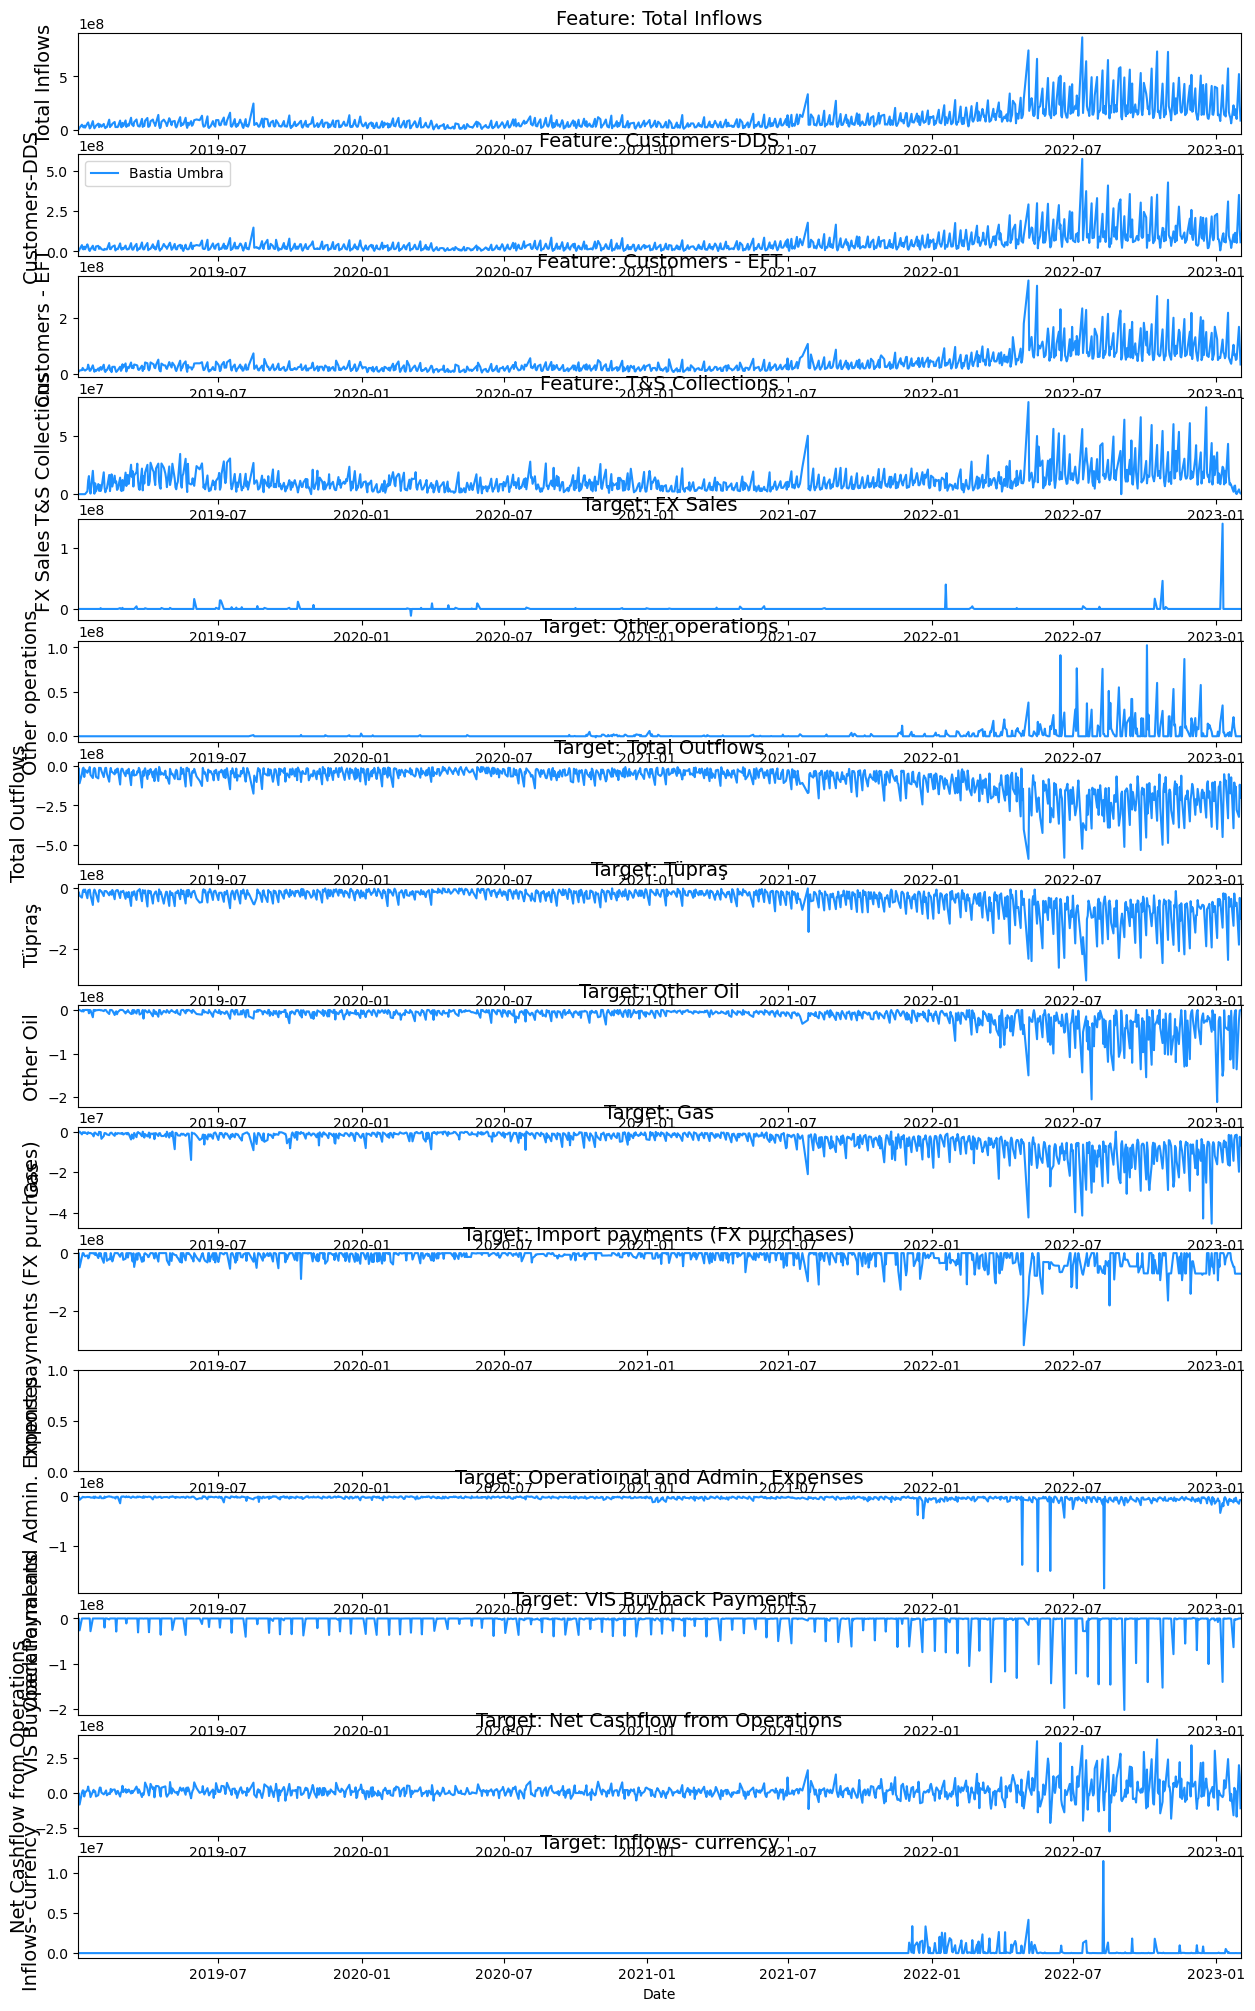

In [21]:
from datetime import date
f, ax = plt.subplots(nrows=16, ncols=1, figsize=(15, 25))

sns.lineplot(x=cash_train.Date, y=cash_train['Total Inflows'].fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Total Inflows', fontsize=14)
ax[0].set_ylabel(ylabel='Total Inflows', fontsize=14)


sns.lineplot(x=cash_train.Date, y=cash_train['Customers - DDS'].fillna(np.inf), ax=ax[1], color='dodgerblue',label='Bastia Umbra')
ax[1].set_title('Feature: Customers-DDS', fontsize=14)
ax[1].set_ylabel(ylabel='Customers-DDS', fontsize=14)


sns.lineplot(x=cash_train.Date, y=cash_train['Customers - EFT'].fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Customers - EFT', fontsize=14)
ax[2].set_ylabel(ylabel='Customers - EFT', fontsize=14)


sns.lineplot(x=cash_train.Date, y=cash_train['T&S Collections'].fillna(np.inf), ax=ax[3], color='dodgerblue')
ax[3].set_title('Feature: T&S Collections', fontsize=14)
ax[3].set_ylabel(ylabel='T&S Collections', fontsize=14)


sns.lineplot(x=cash_train.Date, y=cash_train['FX Sales'].fillna(np.inf), ax=ax[4], color='dodgerblue')
ax[4].set_title('Target: FX Sales', fontsize=14)
ax[4].set_ylabel(ylabel='FX Sales', fontsize=14)

sns.lineplot(x=cash_train.Date, y=cash_train['Other operations'].fillna(np.inf), ax=ax[5], color='dodgerblue')
ax[5].set_title('Target: Other operations', fontsize=14)
ax[5].set_ylabel(ylabel='Other operations', fontsize=14)

sns.lineplot(x=cash_train.Date, y=cash_train['Total Outflows'].fillna(np.inf), ax=ax[6], color='dodgerblue')
ax[6].set_title('Target: Total Outflows', fontsize=14)
ax[6].set_ylabel(ylabel='Total Outflows', fontsize=14)


sns.lineplot(x=cash_train.Date, y=cash_train['Tüpraş'].fillna(np.inf), ax=ax[7], color='dodgerblue')
ax[7].set_title('Target: Tüpraş', fontsize=14)
ax[7].set_ylabel(ylabel='Tüpraş', fontsize=14)

sns.lineplot(x=cash_train.Date, y=cash_train['Other Oil'].fillna(np.inf), ax=ax[8], color='dodgerblue')
ax[8].set_title('Target: Other Oil', fontsize=14)
ax[8].set_ylabel(ylabel='Other Oil', fontsize=14)

sns.lineplot(x=cash_train.Date, y=cash_train['Gas'].fillna(np.inf), ax=ax[9], color='dodgerblue')
ax[9].set_title('Target: Gas', fontsize=14)
ax[9].set_ylabel(ylabel='Gas', fontsize=14)

sns.lineplot(x=cash_train.Date, y=cash_train['Import payments (FX purchases)'].fillna(np.inf), ax=ax[10], color='dodgerblue')
ax[10].set_title('Target: Import payments (FX purchases)', fontsize=14)
ax[10].set_ylabel(ylabel='Import payments (FX purchases)', fontsize=14)


sns.lineplot(x=cash_train.Date, y=cash_train['Operatioınal and Admin. Expenses'].fillna(np.inf), ax=ax[12], color='dodgerblue')
ax[12].set_title('Target: Operatioınal and Admin. Expenses', fontsize=14)
ax[12].set_ylabel(ylabel='Operatioınal and Admin. Expenses', fontsize=14)

sns.lineplot(x=cash_train.Date, y=cash_train['VIS Buyback Payments'].fillna(np.inf), ax=ax[13], color='dodgerblue')
ax[13].set_title('Target: VIS Buyback Payments', fontsize=14)
ax[13].set_ylabel(ylabel='VIS Buyback Payments', fontsize=14)


sns.lineplot(x=cash_train.Date, y=cash_train['Net Cashflow from Operations'].fillna(np.inf), ax=ax[14], color='dodgerblue')
ax[14].set_title('Target: Net Cashflow from Operations', fontsize=14)
ax[14].set_ylabel(ylabel='Net Cashflow from Operations', fontsize=14)


sns.lineplot(x=cash_train.Date, y=cash_train['Inflows- currency'].fillna(np.inf), ax=ax[15], color='dodgerblue')
ax[15].set_title('Target: Inflows- currency', fontsize=14)
ax[15].set_ylabel(ylabel='Inflows- currency', fontsize=14)

for i in range(16):
    ax[i].set_xlim([date(2019, 1, 2), date(2023, 2, 1)])

plt.show()


When we look at the graphics, we can see that some features are stationary and some are non-stationary. To better understand this, we will apply the Augmented Dickey Fuller test.

**ADF (Augmented Dickey-Fuller) Test**

The Augmented Dickey-Fuller (ADF) test is a statistical test used to determine whether a time series dataset is stationary or non-stationary. It is commonly employed in econometrics and time series analysis.

Stationarity refers to a property of a time series where its statistical properties, such as mean, variance, and autocovariance, do not change over time. Non-stationarity, on the other hand, implies that the statistical properties of the time series exhibit some form of trend or pattern, making it difficult to analyze and model accurately.

In [22]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):

    result = adfuller(series.values,autolag='AIC')

    print('ADF Statistic: %f' % result[0])
    print(f'n_lags: {result[1]}')
    print(f'p-value:  {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [23]:
values=['Total Inflows', 'Customers - DDS', 'Customers - EFT',
       'T&S Collections', 'FX Sales', 'Other operations', 'Total Outflows',
       'Tüpraş', 'Other Oil', 'Gas', 'Import payments (FX purchases)', 'Tax',
       'Operatioınal and Admin. Expenses', 'VIS Buyback Payments',
       'Net Cashflow from Operations', 'Inflows- currency']

In [24]:
for i in values:
    print(f' {i}')
    print('--------------')
    check_stationarity(cash_train[i])

 Total Inflows
--------------
ADF Statistic: -0.502506
n_lags: 0.8915265510194319
p-value:  0.8915265510194319
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Non-stationary
 Customers - DDS
--------------
ADF Statistic: -0.337166
n_lags: 0.9200731044388257
p-value:  0.9200731044388257
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Non-stationary
 Customers - EFT
--------------
ADF Statistic: -0.788293
n_lags: 0.8225367927161729
p-value:  0.8225367927161729
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Non-stationary
 T&S Collections
--------------
ADF Statistic: -2.685480
n_lags: 0.0765846584339709
p-value:  0.0765846584339709
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Non-stationary
 FX Sales
--------------
ADF Statistic: -31.624066
n_lags: 0.0
p-value:  0.0
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Stationary
 Other operations
--------------
ADF Statistic: -1.436823
n_lags: 0.5645010721708986
p-value:  0.5645010721708986
Critical Values:
	

**Explanation of statistic result for Net Cashflow from Operations**



**ADF Statistic: -3.043672**

The ADF statistic is the test statistic calculated from the ADF regression model. In this case, the calculated value is -3.043672. The magnitude of the ADF statistic indicates the strength of the evidence against the null hypothesis. A more negative value suggests stronger evidence in favor of stationarity.


**p-value: 0.031012438240133083**

The p-value is a crucial component of hypothesis testing. It measures the probability of observing the ADF statistic (or a more extreme value) under the assumption that the null hypothesis is true. In this case, the obtained p-value is 0.031012438240133083. Typically, if the p-value is below a chosen significance level (e.g., 0.05 or 0.01), it provides evidence to reject the null hypothesis. In this case, since the p-value is less than 0.05, we can reject the null hypothesis of non-stationarity and conclude that the time series is stationary.


**Critical Values:**

The critical values represent threshold values used to compare against the ADF statistic. They are used to determine whether the ADF statistic is sufficiently extreme to reject the null hypothesis. The critical values depend on the chosen significance level. In your result, the critical values for three commonly used significance levels are provided:

1%: -3.437

5%: -2.864

10%: -2.568

If the ADF statistic is more negative than the corresponding critical value, it provides stronger evidence against the null hypothesis. In this case, since the ADF statistic (-3.043672) is more negative than the critical values at the 5% and 10% significance levels (-2.864 and -2.568, respectively), it further supports the rejection of the null hypothesis and suggests the time series is stationary.

We see from the above results that some features are non-stationary. Normally, If the data is not stationary, the data has to be transformed. However, we will use the Prophet model to forecast future cash flow. In the Prophet model, it is not necessary to convert non-stationary features to stationary explicitly. The Prophet model, developed by Facebook, is designed to handle time series data with various characteristics, including both stationary and non-stationary components. 

If you have non-stationary data and you want to use a different modeling technique, you can make your data stationary by applying the techniques I will list below.

There are various methods to make a time series stationary, such as:

**Differencing**: Take the difference between consecutive observations. This can help remove trends or seasonality in the data.

**Transformation**: Apply mathematical transformations like logarithmic or square root transformations to stabilize the variance in the data.

**Decomposition**: Separate the time series into trend, seasonality, and residual components using techniques like seasonal decomposition of time series (STL) or moving averages. Then, work with the detrended and deseasonalized series.

Once you have made the time series stationary, you can proceed with further analysis, such as modelling relationships between the target and other features, forecasting, or conducting statistical tests.

**Autocorrelation Function(ACF) Plot**

An Autocorrelation Function (ACF) plot is a visual tool used in time series analysis to identify and understand the autocorrelation within a time series. Autocorrelation refers to the correlation between a time series and its lagged values.

[ 1.          0.11587264 -0.09286233 -0.21580354 -0.11736892 -0.01722002
 -0.08948695 -0.10394161 -0.21431151 -0.02482262  0.20467431  0.42106648
  0.12135183 -0.10601056 -0.09435939 -0.11820332 -0.0810879  -0.0754282
 -0.01085702 -0.0963385  -0.00524038  0.16746033  0.25514907  0.10326277
 -0.07890555 -0.04896461 -0.15598806 -0.10576095 -0.02785347  0.0201965
  0.02722967 -0.10059942  0.16625036  0.15384309  0.07375419 -0.01811116
 -0.1040638  -0.11453689 -0.14872207  0.06631127  0.03270299  0.0372918
 -0.07252974  0.08708716  0.10577722  0.04633899  0.0276026  -0.12660794
 -0.11329674 -0.08297429  0.06278324  0.05240912 -0.00600763 -0.0555398
  0.06052616  0.08814645 -0.00587892 -0.00622039 -0.08943187 -0.03399437
 -0.04115806  0.01449265  0.03733011 -0.03806619  0.01589278  0.0218699
  0.05336702 -0.02599515 -0.02348417 -0.00236614 -0.0496405 ]


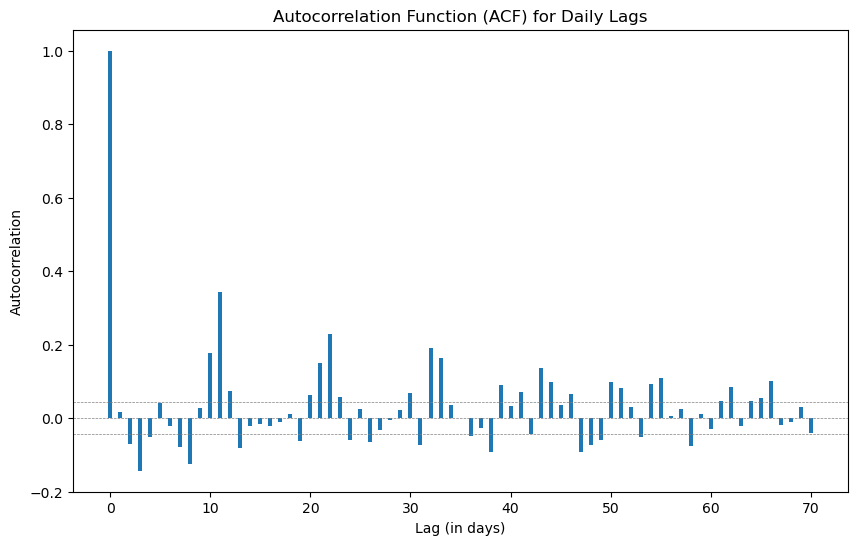

In [25]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# and a corresponding DateTime index representing weekly dates

# Compute the autocorrelation function (ACF)
acf_values, confidence_interval = sm.tsa.acf(cash_train['Net Cashflow from Operations'], nlags=70, alpha=0.05)
print(acf(acf_values,nlags=70))
# Plot the ACF
plt.figure(figsize=(10, 6))
plt.bar(range(len(acf_values)), acf_values, width=0.4)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=-confidence_interval[1][0], color='gray', linestyle='--', linewidth=0.5)
plt.axhline(y=confidence_interval[1][0], color='gray', linestyle='--', linewidth=0.5)
plt.xlabel('Lag (in days)')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) for Daily Lags')
plt.show()


The values in this ACF output represent the autocorrelation coefficients for the daily time series. The blue area depicts the 95% confidence interval and is in indicator for the significance threshold.  As the lag values increase, we can see that it has an uneven distribution.

Based on the provided correlation coefficients, here are some general observations:

The autocorrelation coefficient at 0 lag is 1, that is, each observation value is perfectly autocorrelated with itself.

The correlation coefficient at lag 1 (0.11587264) indicates a weak positive autocorrelation between the time series and the preceding day's observation.

The correlation coefficients at lags 2 to 4 (-0.09286233, -0.21580354, -0.11736892) suggest negative autocorrelation, but the magnitudes are relatively small.

As you move further in the lags, the correlation coefficients continue to fluctuate but gradually decrease in magnitude, indicating a weaker autocorrelation.

Overall, without the exact lag values, it is challenging to provide a more precise interpretation. However, the given correlation coefficients suggest some level of autocorrelation in the daily time series, albeit with varying magnitudes and directions at different lags.

**Lag Plots**

A lag plot is a scatter plot that compares a time series to a lagged version of itself. It is commonly used to examine the presence of autocorrelation in the data. Autocorrelation refers to the relationship between an observation and its previous observations in the series.

By plotting the time series against its lagged values, we can visually inspect whether there is any discernible pattern or structure in the data. If a clear pattern exists, it indicates the presence of autocorrelation in the series. On the other hand, if the plot appears random without any noticeable pattern, it suggests that the series may resemble random white noise.

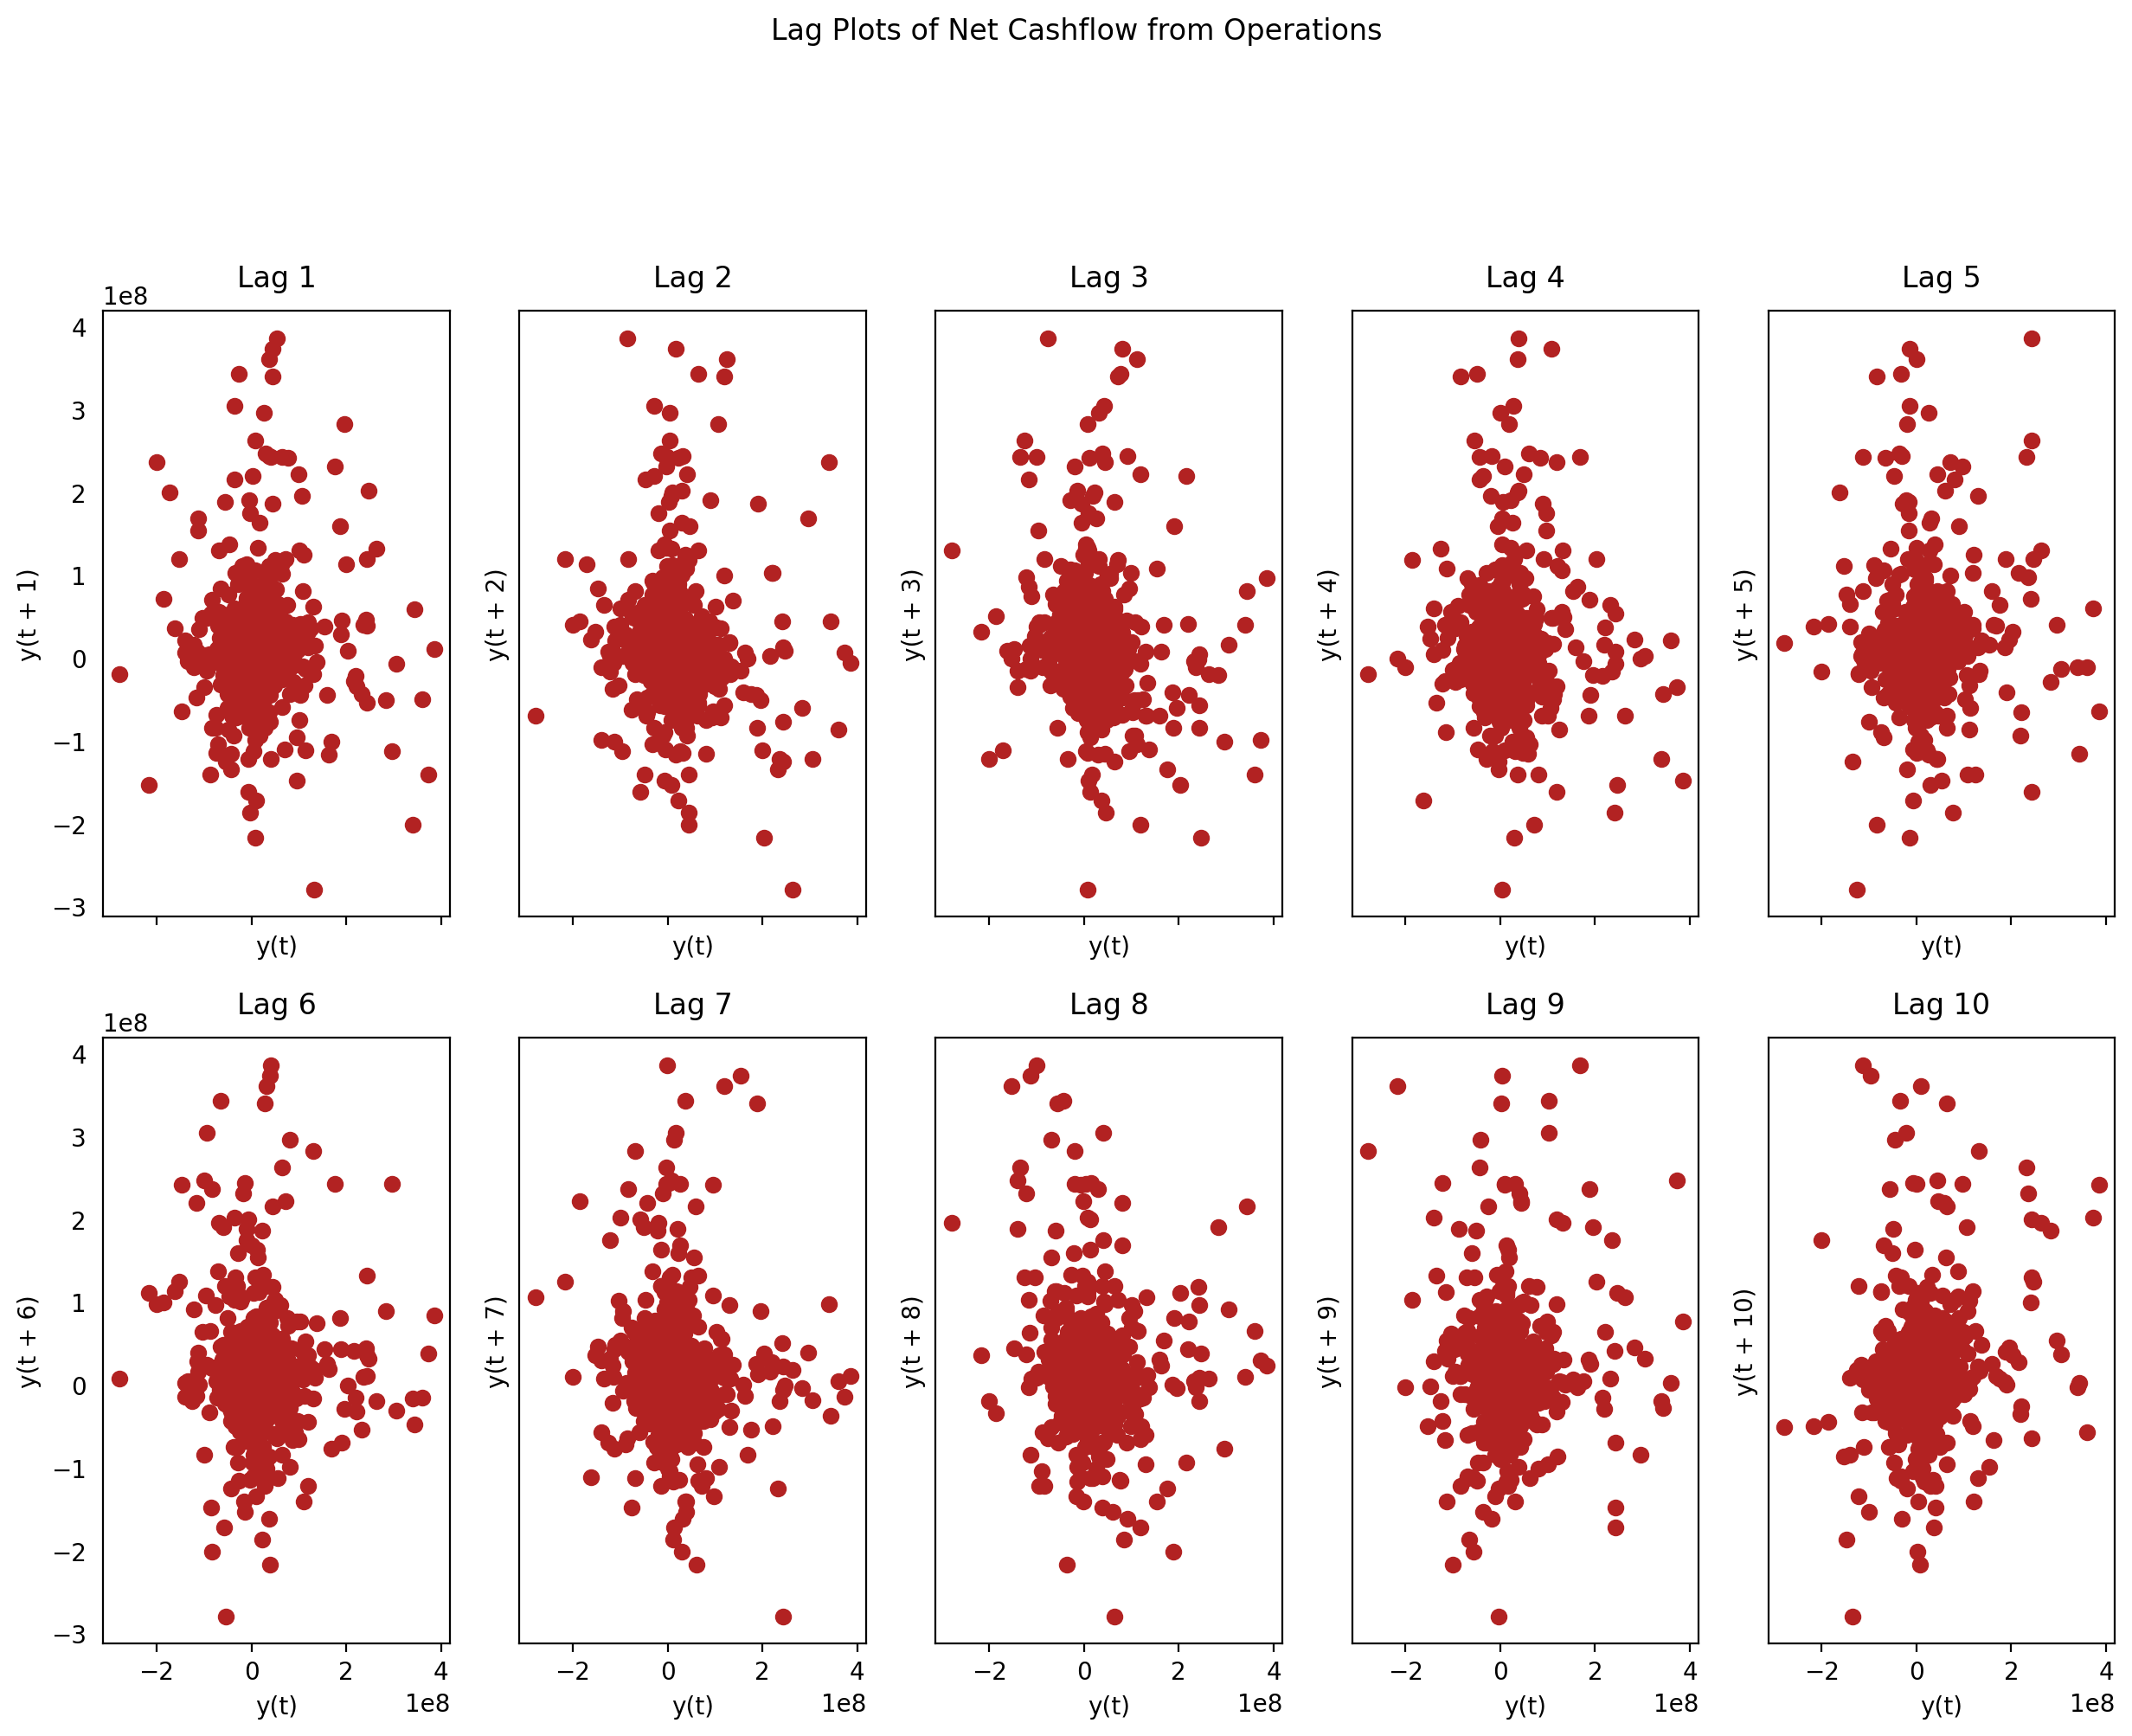

In [26]:
from pandas.plotting import lag_plot
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(2, 5, figsize=(15,10), sharex=True, sharey=True, dpi=200)
m=1
for i, ax in enumerate(axes.flatten()[:10]):
   
    lag_plot(cash_train['Net Cashflow from Operations'], lag=m,ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(m))
    m=m+1

fig.suptitle('Lag Plots of Net Cashflow from Operations', y=1.05)    
plt.show()

When we look at only 10 lags, we see clearly random white noise. 
Random white noise refers to a series of uncorrelated and independent random values. It has no specific pattern, trend, or autocorrelation. In other words, each value in the series is unrelated to the previous or future values, and there is no systematic relationship between them.

 **Detecting Outliers**

An outlier is a data point that significantly deviates from the overall pattern or trend of a dataset. It is an observation that lies an abnormal distance away from other similar observations in a statistical distribution. Outliers can occur due to various reasons, such as measurement errors, data entry mistakes, or genuine extreme values in the data.

Outliers can have a disproportionate impact on statistical analysis and modelling techniques. They can skew the results, affect the accuracy of descriptive statistics (e.g., mean and standard deviation), and influence the performance of predictive models. Removing outliers is often done to ensure the data is representative of the underlying population or to prevent these extreme values from unduly influencing the analysis.

There are several technics to detect outliers. One of technic is to plot the data. We can say that it can be an initial step in identifying outliers. Box plots can help visualize the distribution and identify any data points that appear to be distant from the main cluster.

First, we determine the names of the features for which we will draw the boxplot. In other words, we get data of float type.

In [27]:
column_name=['Sales Volumes in L15', 'Total Inflows', 'Customers - DDS',
       'Customers - EFT', 'T&S Collections', 'FX Sales', 'Other operations',
       'Total Outflows', 'Tüpraş', 'Other Oil', 'Gas',
       'Import payments (FX purchases)', 'Tax',
       'Operatioınal and Admin. Expenses', 'VIS Buyback Payments',
       'Net Cashflow from Operations', 'Inflows- currency', 'AB Piyasa Fiyatı',
       'AB Piyasa Fiyatı- Yüksek', 'AB Piyasa Fiyatı- Düşük',
       'Dolar Kuru (Satış)', 'IMM TL/m3', 'Pump Price', 'Depot Price']

we will draw a box plot for each feature.

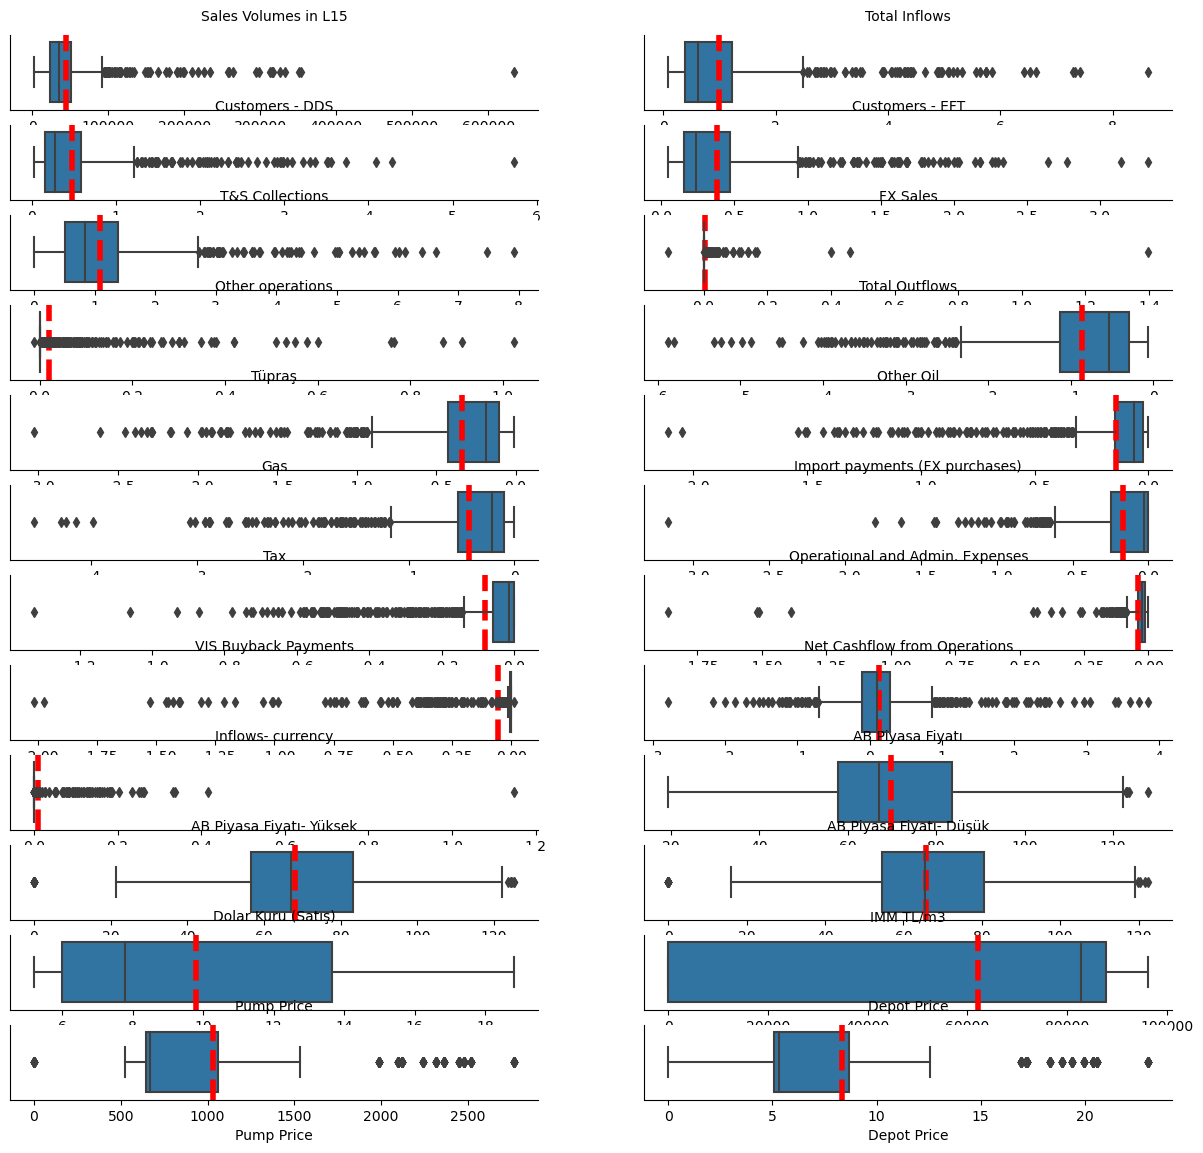

In [28]:
a = 13  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter
fig = plt.figure(figsize=(15,15))
plt.title('Outliers', fontsize=18)
for i in column_name:
    plt.subplot(a, b, c)
    plt.title(i, fontsize=10)
    sns.boxplot(x=cash_train[i])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.axvline(cash_train[i].mean(), linestyle='--', lw=4, zorder=1, color='red')
    plt.xlabel(i)
    c=c+1
    
plt.show()

When we look at each boxplot, there are lots of outliers. We need to remove these outliers to improve the accuracy and minimise the impact of influential points.

**Remove Outliers**

Before removing outliers, we will control the data on how many outliers have. For this, we will use the Interquartile Range (IQR) method.

In [29]:
def find_outliers(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    IQR=q3-q1
    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
    return outliers

outliers = find_outliers(cash_train['Net Cashflow from Operations'])

print('The number of outliers: '+ str(len(outliers)))

print('Max outlier value: '+ str(outliers.max()))

print('Min outlier value: ' + str(outliers.min()))

The number of outliers: 100
Max outlier value: 385721458.2750001
Min outlier value: -278863675.4525


The code explanation for finding outliers:


* **q1 = df.quantile(0.25)** : It calculates the first quartile (25th percentile) of the data.

* **q3 = df.quantile(0.75)**: It calculates the third quartile (75th percentile) of the data.

* **IQR = q3 - q1**: It calculates the interquartile range by subtracting the first quartile from the third quartile.

* **outliers = df[((df < (q1 - 1.5 * IQR)) | (df > (q3 + 1.5 * IQR)))]**: It identifies outliers as the values in the DataFrame that are below (q1 - 1.5 * IQR) or above (q3 + 1.5 * IQR).

There are 100 outliers in net cash flow operation features. Min and max values are -278863675.4525 and 385721458.2750001 respectively.

We used the z-normalization method for 'net cashflow from operations' values to remove the outliers.

In [30]:
data = sorted(cash_train['Net Cashflow from Operations'].values)
data_mean, data_std = np.mean(data), np.std(data)
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
print('Cut Off =', round(cut_off,3))
print('Lower =', round(lower,3))
print('Upper =', round(upper,3))

Cut Off = 175539556.278
Lower = -161984317.049
Upper = 189094795.507


We explain each row of the code :

*  **data = sorted(cash_train['Net Cashflow from Operations'].values)**: .
It retrieves the values from this column, and sorts them in ascending 
order.

* **data_mean, data_std = np.mean(data), np.std(data)**: The code calculates the mean and standard deviation of the data using the NumPy library.

* **cut_off = data_std * 3**: The code multiplies the standard deviation by 3 and assigns the result to cut_off. This step determines the threshold for defining outliers. In the Z-score method, a common threshold is 3 standard deviations away from the mean.

* **lower, upper = data_mean - cut_off, data_mean + cut_off**: The code calculates the lower and upper bounds for identifying outliers. The lower bound is obtained by subtracting the cut_off value from the mean, and the upper bound is obtained by adding the cut_off value to the mean.

After determining the upper and lower bounds, we will apply to data.

In [31]:
cash_train = cash_train[cash_train['Net Cashflow from Operations'] < upper]
cash_train= cash_train[cash_train['Net Cashflow from Operations'] > lower]
print('The shape of our dataframe after the Outlier Removal is', cash_train.shape)

The shape of our dataframe after the Outlier Removal is (997, 25)


We will check the outliers. There are 79 outliers in the data.

In [32]:
outliers = find_outliers(cash_train['Net Cashflow from Operations'])
print('The number of outliers: '+ str(len(outliers)))

The number of outliers: 79


After removing outliers,  we saw that there are many outliers in the data. Instead of again removing these outliers,  we will apply outlier imputation. The purpose of doing this technic is that: Preserving sample size and statistical power and maintain data distribution and variability. 

In [33]:
def impute_outliers(df):

    q1=df.quantile(0.25)

    q3=df.quantile(0.75)

    IQR=q3-q1

    upper = df[~(df>(q3+1.5*IQR))].max()

    lower = df[~(df<(q1-1.5*IQR))].min()

    df = np.where(df > upper,

       df.mean(),

       np.where( df < lower,df.mean(),df)

       )

    return df

cash_train['Net Cashflow from Operations'] = impute_outliers(cash_train['Net Cashflow from Operations'])

When we examine the code snippet:

* **q1 = df.quantile(0.25)**: It calculates the first quartile (25th percentile) of the data.

* **q3 = df.quantile(0.75)**: It calculates the third quartile (75th percentile) of the data.

* **IQR = q3 - q1**: It calculates the interquartile range by subtracting the first quartile from the third quartile.

* **upper = df[~(df > (q3 + 1.5 * IQR))].max()**: It finds the maximum value within the data that is not considered an outlier (values not greater than (q3 + 1.5 * IQR)).
* **lower = df[~(df < (q1 - 1.5 * IQR))].min()**: It finds the minimum value within the data that is not considered an outlier (values not less than (q1 - 1.5 * IQR)).
* **df = np.where(df > upper, df.mean(), np.where(df < lower, df.mean(), df))**: It replaces the outlier values in the cash train dataframe with the mean of the non-outlier values. The np. where the function is used to perform the conditional replacement.

The function returns the modified data frame with imputed outliers.

**Moving Average**

A moving average is a statistical calculation used to analyze data points over a certain period of time. It is commonly used in time series analysis to smooth out fluctuations and identify trends or patterns in data. 
The moving average is calculated by taking the average of a specified number of data points within a sliding window. As new data points become available, the oldest data point is dropped from the calculation, and the newest data point is included. This sliding window moves sequentially through the data, calculating the average for each window.

For optimal choosing the windows size, we calculate the mean absolute error and mean squared error. The window size that results in the lowest RMSE or MAE can be considered the optimal choice for achieving the desired level of smoothing.

In [34]:

train_set = cash_train[:-70]
val_set = cash_train[-70:]

from sklearn.metrics import mean_squared_error, mean_absolute_error
# window sizes to evaluate
window_sizes = [1,2,3,4,5, 10, 20, 30, 40,50,70,100,200]

# Calculate RMSE or MAE for each window size
results = []
for window_size in window_sizes:
    # Calculate moving average on the training set
    moving_avg = train_set['Net Cashflow from Operations'].rolling(window=window_size).mean().dropna()

    # Forecast using the moving average on the validation set
    forecast = moving_avg[-70:]

    # Calculate RMSE or MAE
    rmse = mean_squared_error(val_set['Net Cashflow from Operations'], forecast, squared=False)
    mae = mean_absolute_error(val_set['Net Cashflow from Operations'], forecast)

    results.append((window_size, rmse, mae))

# Print the results
print("Window Size\tRMSE\t\tMAE")
for result in results:
    print(f"{result[0]}\t\t{result[1]}\t{result[2]}")


Window Size	RMSE		MAE
1		41666439.62061769	30860065.93395187
2		37390272.90049226	27800068.650718313
3		35175361.0454069	26586047.54624805
4		35446690.4158087	26699872.702097945
5		35554186.34636736	26753874.11875131
10		35608071.06523832	27052731.893857863
20		34166212.04539066	26426495.309581436
30		34328448.03964989	26691572.93129676
40		34238869.69183979	26925677.797816217
50		34137334.911556214	26747873.73207335
70		34378610.05020927	26816715.177170713
100		34592655.50335854	26468773.074192204
200		34609564.923338026	26122860.39862488


We split time series data into two parts: a training set and a validation set. The training set should contain the majority of the data, while the validation set should cover the  70-days period of time forecasting. 

For each window size, we calculate the moving average on the training set and then the RMSE or MAE between the forecasted values and the actual values in the validation set.

Smaller window sizes are higher RMSE values than for larger window sizes, it indicates that the forecasts based on smaller window sizes are relatively less accurate in terms of percentage error compared to the forecasts based on larger window sizes. Even when we increase the number of windows, there is no significant decrease in RMSE.

*  **20 Days Moving Average**

In [35]:
cash_train=cash_train.reset_index()

In [36]:
indexedDay = cash_train.set_index('Date')

In [37]:
indexedDay=indexedDay.drop([ 'Sales Volumes in L15', 'Total Inflows', 'Customers - DDS',
       'Customers - EFT', 'T&S Collections', 'FX Sales', 'Other operations',
       'Total Outflows', 'Tüpraş', 'Other Oil', 'Gas',
       'Import payments (FX purchases)', 'Tax',
       'Operatioınal and Admin. Expenses', 'VIS Buyback Payments', 'Inflows- currency', 'AB Piyasa Fiyatı',
       'AB Piyasa Fiyatı- Yüksek', 'AB Piyasa Fiyatı- Düşük',
       'Dolar Kuru (Satış)', 'IMM TL/m3', 'Pump Price', 'Depot Price'],axis=1)

Text(0.5, 1.0, '20 Days Moving Average')

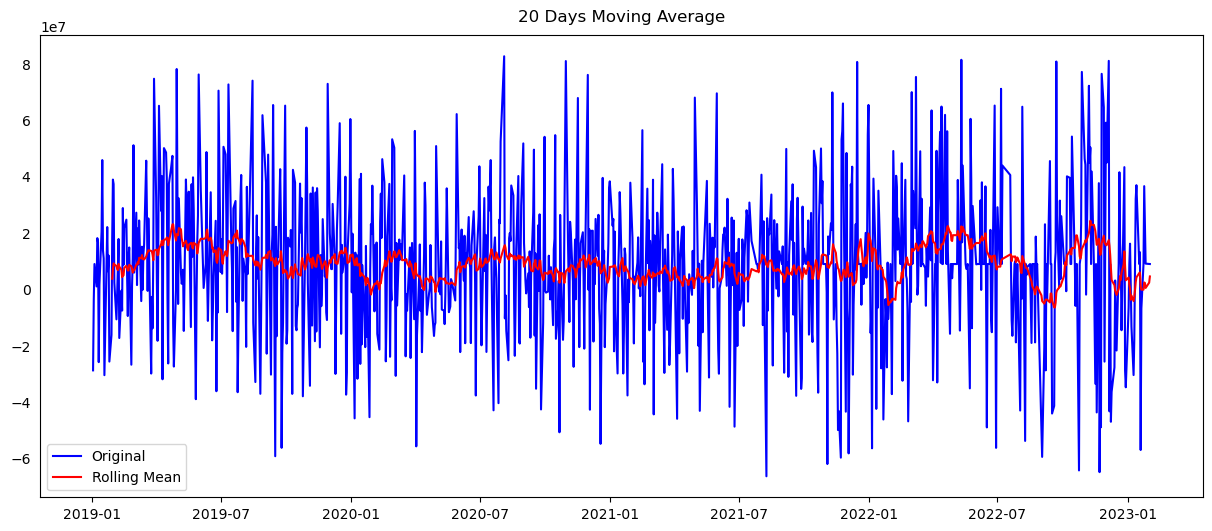

In [38]:

fig, ax = plt.subplots(figsize=(15, 6))
moving_average20 = indexedDay['Net Cashflow from Operations'].rolling(window=20).mean()
plt.plot(indexedDay['Net Cashflow from Operations'], color='blue', label='Original')
plt.plot(moving_average20, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('20 Days Moving Average')

* **40 Days Average Moving**

Text(0.5, 1.0, '40 Days Moving Average')

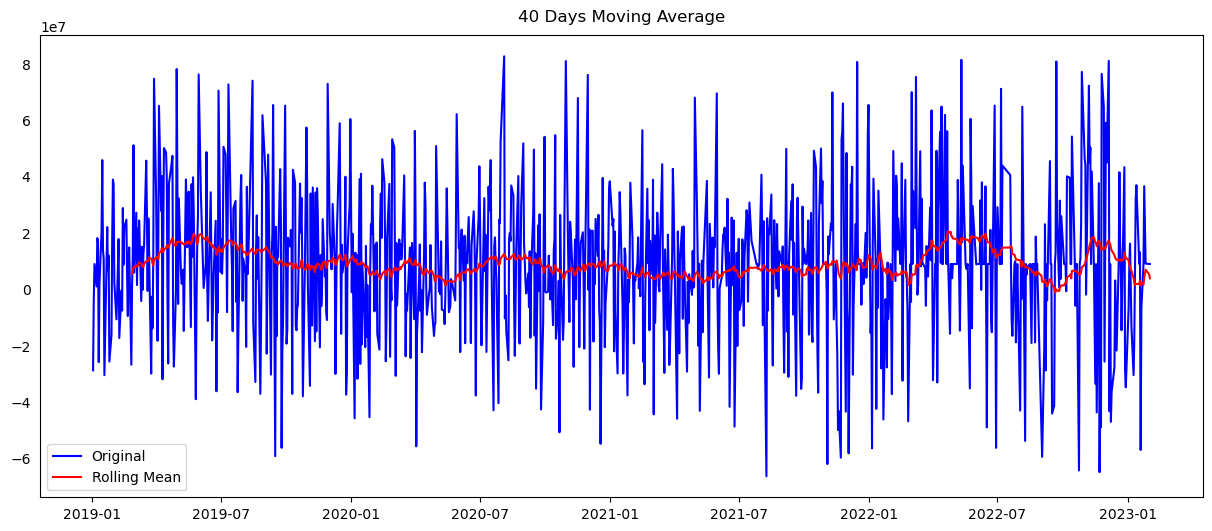

In [39]:
fig, ax = plt.subplots(figsize=(15, 6))
moving_average40 = indexedDay['Net Cashflow from Operations'].rolling(window=40).mean()
plt.plot(indexedDay['Net Cashflow from Operations'], color='blue', label='Original')
plt.plot(moving_average40, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('40 Days Moving Average')

* **50 Days Moving Average**

Text(0.5, 1.0, '50 Days Moving Average')

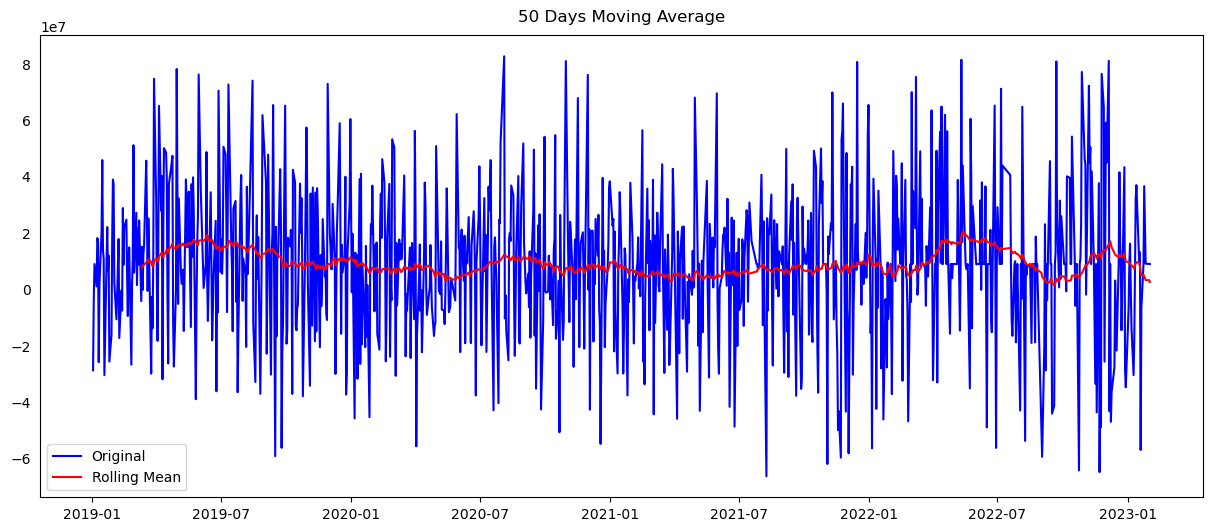

In [40]:
fig, ax = plt.subplots(figsize=(15, 6))
moving_average50 = indexedDay['Net Cashflow from Operations'].rolling(window=50).mean()
plt.plot(indexedDay['Net Cashflow from Operations'], color='blue', label='Original')
plt.plot(moving_average50, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('50 Days Moving Average')

* **70 Days Moving Average**

Text(0.5, 1.0, '70 Days Moving Average')

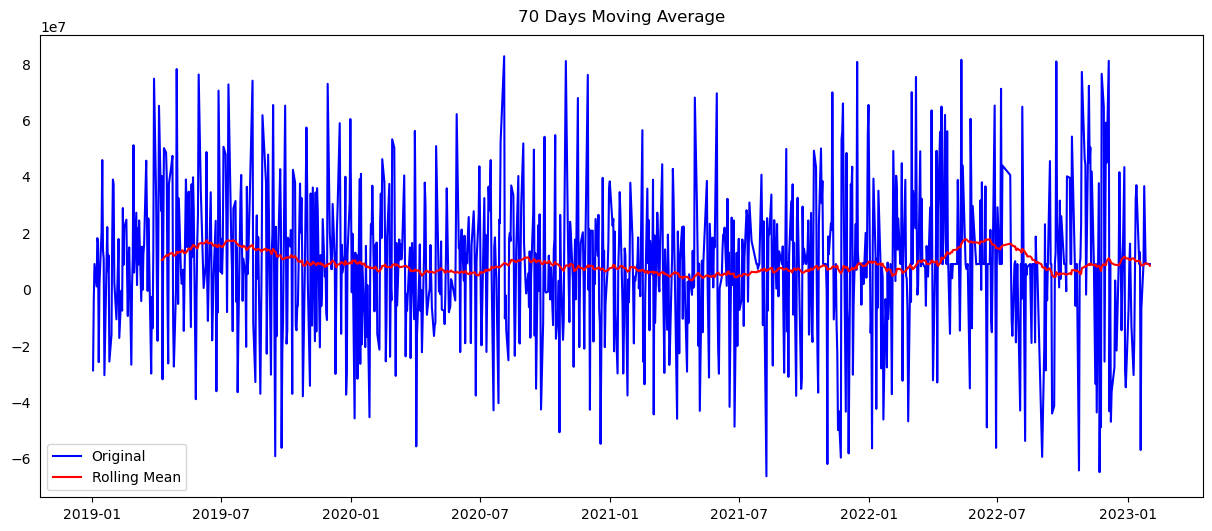

In [41]:
fig, ax = plt.subplots(figsize=(15, 6))
moving_average70 = indexedDay['Net Cashflow from Operations'].rolling(window=70).mean()
plt.plot(indexedDay['Net Cashflow from Operations'], color='blue', label='Original')
plt.plot(moving_average70, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('70 Days Moving Average')

* **100 Days Moving Average**

Text(0.5, 1.0, '100 Days Moving Average')

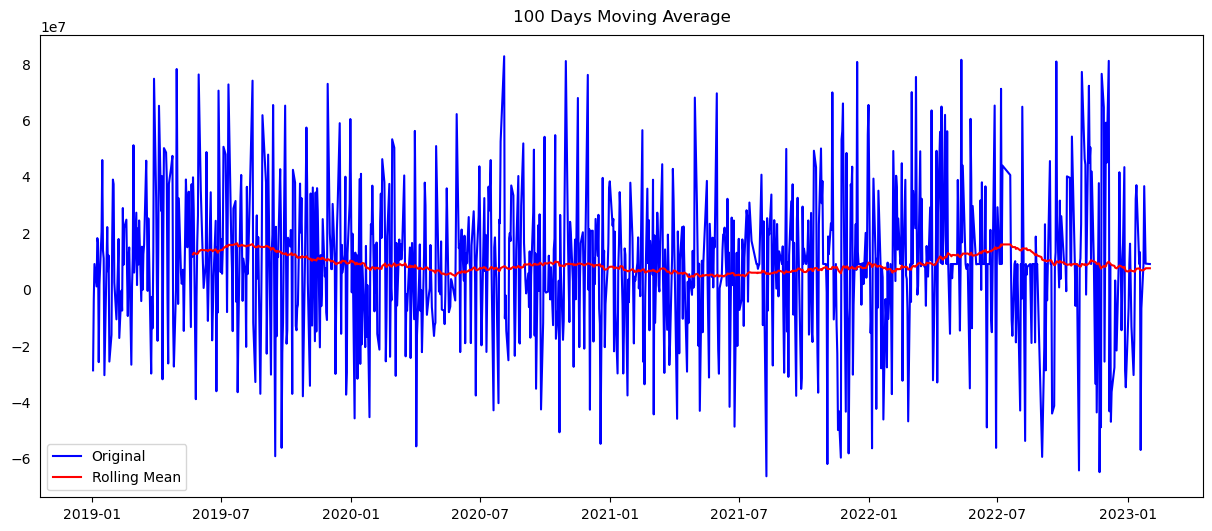

In [42]:
fig, ax = plt.subplots(figsize=(15, 6))
moving_average100 = indexedDay['Net Cashflow from Operations'].rolling(window=100).mean()
plt.plot(indexedDay['Net Cashflow from Operations'], color='blue', label='Original')
plt.plot(moving_average100, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('100 Days Moving Average')

In summary, increasing the window size results in a smoother output but fails to provide an optimal solution,  we can suggest that the data may possess complex patterns or dynamics that are not well-suited for a traditional moving average approach. The lack of an optimal window size might indicate that the data contains complex patterns, such as non-linear trends, seasonality, or irregular fluctuations. Moving averages, being a linear smoothing technique, may struggle to capture these complexities.

# Feature Extraction

We derivated new features from existing features. The objective is to create ones that do a better representing a forecasting problem to the model. By doing so, we can improve the accuracy of the model.In addition, we extracted four different new features, you can see them in the below

**Extracting Date Time Features**

 Temporal aspects of the time series is date time features , such as time of day, day of the week, month, or year. These features can be useful for capturing cyclic patterns or seasonality in the data. We extract day, quarter, month, year, day of year, week of year, weekday and season.

In [43]:
cash_train=cash_train.reset_index(drop=False)

In [44]:

cash_train['Date']=pd.to_datetime(cash_train['Date'])
import math

def date_time_features(df):

  
    df['day'] =df['Date'].dt.day
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = pd.to_datetime(df['Date'], errors='coerce').dt.month
    df['year'] = pd.to_datetime(df['Date'], errors='coerce').dt.year
    df['dayofyear'] = pd.to_datetime(df['Date'], errors='coerce').dt.dayofyear
    df['weekofyear'] = pd.to_datetime(df['Date'], errors='coerce').dt.weekofyear
    df['weekday'] =pd.to_datetime(df['Date'], errors='coerce').dt.weekday 
    df['season'] = df.month%12 // 3 + 1

    
    return df

df = date_time_features(cash_train)

**GrowthRate**

A growth rate measures the change in a variable over a specific period relative to its initial value. It is commonly used in feature extraction to capture a variable's pace of change or expansion over time. To calculate the growth rate, we can use the pct_change() function in pandas. In our project, we used this function for 'VIS_Buyback_Payments'. In addition,pct_change() can be applied to all features. 

In [45]:
def GrowthRate(df):
   
    df['Growth_Rate_VIS_Buyback_Payments']=df['VIS Buyback Payments'].pct_change()

    df['Growth_Rate_VIS_Buyback_Payments']=df['VIS Buyback Payments'].replace([np.inf, -np.inf], np.nan).fillna(0)
  
    return df

In [46]:
df=GrowthRate(df)

**Percentage Contribution**

We created a new feature by taking advantage of the existing features 

We computed the percentage contribution of each revenue source ('Tüpraş', 'Other Oil', 'Gas') to total sales or cash flow.

We calculated the ratio between 'FX Sales TL' and 'Import payments (FX purchases)' to analyze the relationship between the revenue generated from foreign currency sales and the expenses incurred for foreign currency purchases. This ratio can provide insights into the effectiveness of managing foreign exchange transactions.

We calculated the ratio of 'Customers - DDS' to 'Customers - EFT'. This ratio can provide insights into the distribution of customers between different payment methods. 

In [47]:
def extra_features(df):
    total_sales = df['Sales Volumes in L15'].sum()
    total_cashflow = df['Net Cashflow from Operations'].sum()

    df['Tupras_Contribution'] = df['Tüpraş'] / total_sales * 100
    df['Other_Oil_Contribution'] = df['Other Oil'] / total_sales * 100
    df['Gas_Contribution'] = df['Gas'] / total_sales * 100

    df['Tupras_Cashflow_Contribution'] = df['Tüpraş'] / total_cashflow * 100
    df['Other_Oil_Cashflow_Contribution'] = df['Other Oil'] / total_cashflow * 100
    df['Gas_Cashflow_Contribution'] = df['Gas'] / total_cashflow * 100

    
   # df['Pump_to_Depot_Price_Ratio'] = df['Pump Price'] / df['Depot Price']
    #df['Price_Difference'] = df['Pump Price'] - df['Depot Price']
    
   # df['AB Piyasa Price Difference'] = df['AB Piyasa Fiyatı- Yüksek'] - df['AB Piyasa Fiyatı- Düşük']
   # df['Gas_Revenue'] = df['Sales Volumes in L15'] * df['Gas']
    df['FX_Sales_Import_Ratio'] = df['FX Sales'] / df['Import payments (FX purchases)']
    
    df['Ratio of Customers'] = df['Customers - DDS'] / df['Customers - EFT']
    
    
    df['FX_Sales_Import_Ratio']=df['FX_Sales_Import_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
   # df['Pump_to_Depot_Price_Ratio']=df['Pump_to_Depot_Price_Ratio'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df['Tupras_Contribution'] = df['Tupras_Contribution'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df['Other_Oil_Contribution'] = df['Other_Oil_Contribution'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df['Gas_Contribution'] = df['Gas_Contribution'].replace([np.inf, -np.inf], np.nan).fillna(0)
    #df['Price_Difference']=df['Price_Difference'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df['Tupras_Cashflow_Contribution'] = df['Tupras_Cashflow_Contribution'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df['Other_Oil_Cashflow_Contribution'] = df['Other_Oil_Cashflow_Contribution'].replace([np.inf, -np.inf], np.nan).fillna(0)
    df['Gas_Cashflow_Contribution'] = df['Gas_Cashflow_Contribution'].replace([np.inf, -np.inf], np.nan).fillna(0)

    
    return df

In [48]:

df=extra_features(df)

**Seasonal Features**

Seasonal features capture the variations and patterns that occur in data based on the different seasons of the year. Weekday and weekend features capture the distinction between weekdays (typically Monday to Friday) and weekends (usually Saturday and Sunday). These features help in understanding and capturing the variations and patterns that occur during different days of the week.

In [49]:
def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3) & (date.month <= 5)

def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6) & (date.month <= 8)

def is_autumn(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9) & (date.month <= 11)

def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 12) | (date.month <= 2)

def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.day_name in ('Saturday', 'Sunday')




In [50]:
def add_season(df):
    df = df.copy()
#     df.reset_index(inplace=True)
    df['is_spring'] = df['Date'].apply(is_spring)
    df['is_summer'] = df['Date'].apply(is_summer)
    df['is_autumn'] = df['Date'].apply(is_autumn)
    df['is_winter'] = df['Date'].apply(is_winter)
    df['is_weekend'] = df['Date'].apply(is_weekend)
    df['is_weekday'] = ~df['Date'].apply(is_weekend)
    return df

In [51]:
#df=df.reset_index(drop=False)

df = add_season(df)

In [52]:
df=df.drop(['index','level_0'],axis=1)

**Encoding Cyclical Features**

Encoding cyclical features is a technique used to represent periodic or cyclical data, such as time of day, day of the week, or month of the year, in a way that captures their circular nature.  When encoding cyclical features, two common methods are used: sin-cos encoding and circular statistics encoding.

In [53]:
def calculate_sin_cos(df):
    df['sin_month'] = np.sin(2 * np.pi * df['month']/12)
    df['cos_month'] = np.cos(2 * np.pi * df['month']/12)
    df['sin_dayofyear'] = np.sin(2 * np.pi * df['dayofyear']/365)
    df['cos_dayofyear'] = np.cos(2 * np.pi * df['dayofyear']/365)
    df['sin_dayofmonth'] = np.sin(2 * np.pi * df['day']/30)
    df['cos_dayofmonth'] = np.cos(2 * np.pi * df['day']/30)
    df["weekofyear_sin"] = np.sin(2 * np.pi * df['weekofyear']/52)
    df["weekofyear_cos"] = np.cos(2 * np.pi * df['weekofyear']/52)
    df['quarter_sin'] = np.sin(2*np.pi*df.quarter/4)
    df['quarter_cos'] = np.cos(2*np.pi*df.quarter/4)
    df['season_sin'] = np.sin(2*np.pi*df.season/4)
    df['season_cos'] = np.cos(2*np.pi*df.season/4)
    
    return df

In [54]:
df=calculate_sin_cos(df)

**Holiday Features**

Holiday features capture the presence or absence of holidays within a dataset.

In [55]:
holiday = calender[['CALENDAR_DATE','RAMADAN_FLAG','PUBLIC_HOLIDAY_FLAG',"WEEKEND_FLAG"]].rename(columns={'CALENDAR_DATE':'ds'})
holiday['holiday'] =np.where((holiday['RAMADAN_FLAG'] == 'Y') | (holiday['PUBLIC_HOLIDAY_FLAG'] == 'Y')|(holiday['WEEKEND_FLAG'] == 'Y'), 'TR-Holidays', 0)
holiday = holiday[['ds','holiday']]
holiday = holiday[holiday['holiday'] == 'TR-Holidays']

COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,    
})

events = pd.concat((COVID,holiday))

# Corelation Analysis

Correlation declares how the features are related to each other or the target variable. Correlation can be positive or negative. Heatmap makes it easy to identify which features are most related to the target variable. We drop the boolean features before applying correlation.

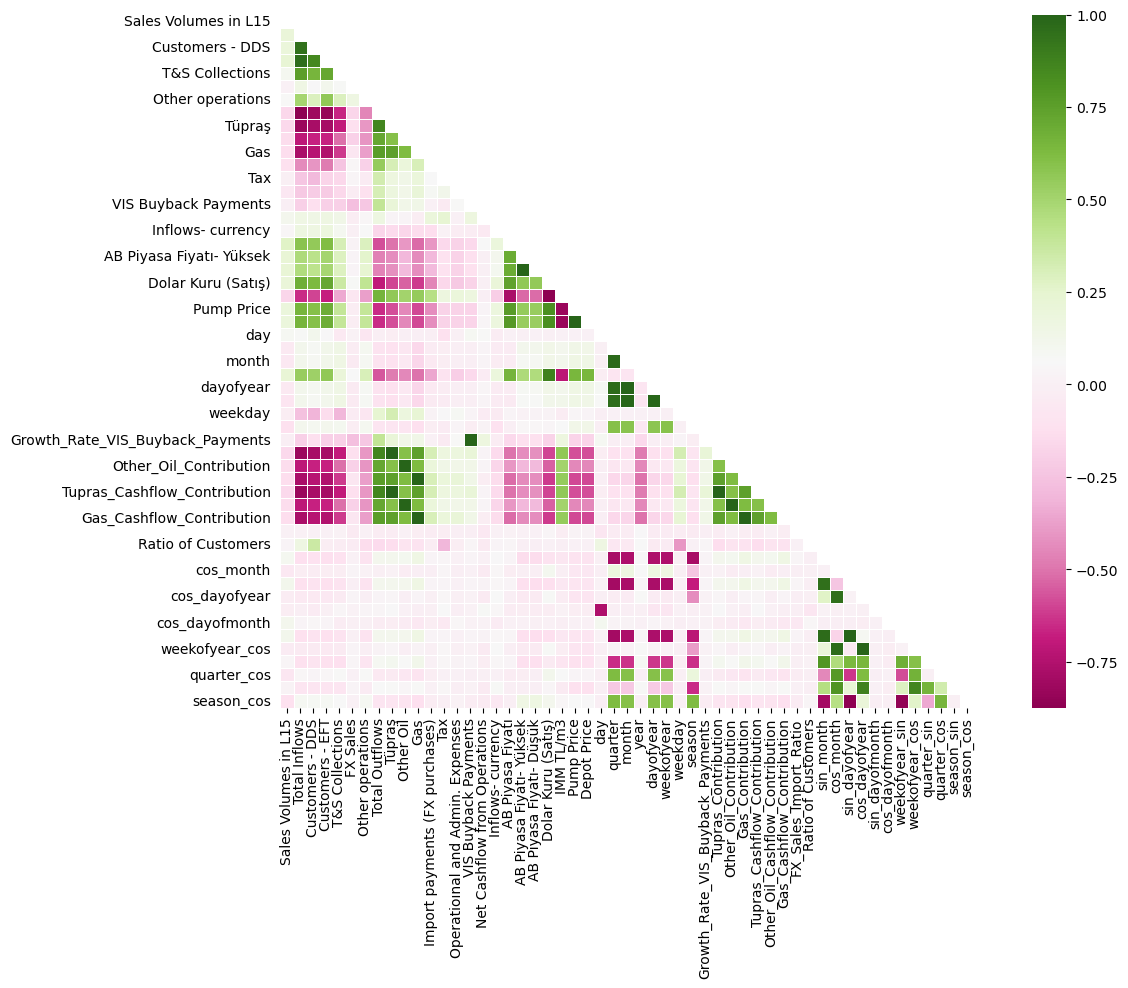

In [56]:
df1=df.drop(['Date','is_spring', 'is_summer', 'is_autumn', 'is_winter',
       'is_weekend', 'is_weekday'] ,axis = 1)


#corr_all = df.drop('is_spring', axis = 1).corr()
corr_all=df1.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (15, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "PiYG")
plt.show()

In the above figure, the heat map shows the relationship between two features. Each two features values must be between -1 and 1. When we explain the map:

**-1** means that there is a negative relationship between 2 features. For example, sin_month and season_cos have a negative relationship. The colour of the value is dark pink

**0** means that there is no relationship between 2 features.

**1** means that there is a positive relationship between 2 features. For example, Pump Price and Depo Price have a strong positive relationship.

# Split Train/Test Data

We split the data into 70 last samples test

In [57]:
df = df.drop(['day', 'quarter','month', 'year', 'dayofyear', 'weekofyear', 'weekday','season'], axis=1)

df=df.fillna(0)

In [58]:
train_data=df[:-70]
test_data=df[-70:]

In [59]:
train_data.shape, test_data.shape

((927, 52), (70, 52))

# Net Cash Flow Forecasting using Prophet 

Prophet is a forecasting library developed by Facebook's Core Data Science team. It is designed to provide an easy-to-use and scalable framework for time series forecasting. Prophet's main goal is to simplify the process of creating accurate forecasts, even for users with little experience in time series modelling.


We will use the Prophet library for predicting future values. Before using this library, we need to import it. Use the below code snippets to download the library:

* pip install prophet

* from prophet import Prophet


Now, we are ready to work on this library.


First of all, we will start with creating a model. In our model, we need to add seasonality, holidays and many regressors to increase performance.  For seasonality, we will analyze yearly, weekly and daily, add to the model, and then use extracted features for regressor.

In [60]:
def create_model():
    
    model = Prophet(holidays=events)
   

    model.add_seasonality(name='yearly', 
                          period=365.25, 
                          fourier_order=10)
   
    model.add_seasonality(name='weekly_spring', 
                            period=7,
                            fourier_order=5, 
                            condition_name='is_spring')
    model.add_seasonality(name='weekly_summer', 
                            period=7,
                            fourier_order=5, 
                            condition_name='is_summer')
    model.add_seasonality(name='weekly_autumn', 
                            period=7,
                            fourier_order=5, 
                            condition_name='is_autumn')
    model.add_seasonality(name='weekly_winter', 
                            period=7,
                            fourier_order=5, 
                            condition_name='is_winter')
   
    model.add_seasonality(name='weekly_is_weekday',
                            period=7,
                            fourier_order=5,
                            condition_name='is_weekday')
  
    model.add_seasonality(name='daily_spring',  
                            period=1,
                            fourier_order=5, 
                            condition_name='is_spring')
    model.add_seasonality(name='daily_summer',  
                            period=1,
                            fourier_order=15, 
                            condition_name='is_summer')
    model.add_seasonality(name='daily_autumn',  
                            period=1,
                            fourier_order=5, 
                            condition_name='is_autumn')
    model.add_seasonality(name='daily_winter',  
                            period=1,
                            fourier_order=5, 
                            condition_name='is_winter')
   
    model.add_seasonality(name='daily_is_weekday',
                            period=1,
                            fourier_order=5,
                            condition_name='is_weekday')
    model.add_seasonality(name='daily_weekend',
                          period=2,
                          fourier_order=5, 
                          condition_name='is_weekend')
   
    
   
    regressor_list =['Total Inflows',
       'Customers - DDS', 'Customers - EFT', 'T&S Collections','FX Sales',
       'Other operations', 'Total Outflows', 'Tüpraş', 'Other Oil', 'Gas',
       'Import payments (FX purchases)', 'Tax',
       'Operatioınal and Admin. Expenses', 'VIS Buyback Payments','Inflows- currency','sin_month', 'cos_month', 'sin_dayofyear', 'cos_dayofyear',
       'sin_dayofmonth', 'cos_dayofmonth','Tupras_Cashflow_Contribution', 'Other_Oil_Cashflow_Contribution',
       'Gas_Cashflow_Contribution','FX_Sales_Import_Ratio','Ratio of Customers','Other_Oil_Contribution','Gas_Contribution',
       'Growth_Rate_VIS_Buyback_Payments',
       
        ]
    
     
    for i in regressor_list:
        
        model.add_regressor(i)

    return model

The Prophet() object takes arguments to configure the type of model you want, such as the type of growth, the type of seasonality, and more.



In [61]:
model = create_model()

The fit() function takes a DataFrame for the date time stamp. The data frame must have a specific format. The first column must have the name ‘ds‘ and contain the date times. The second column must have the name ‘y‘ and contain target the samples. In our project, ds is also the Date column and y is the net cash flow operation column. We try to find future sales values. For this reason, our observations/samples are net cash flow from operation values. For this reason, we will convert to date feature name as 'ds' and net cash flow from operations as 'y'

In [62]:
train_data=train_data.rename(columns={'Date':'ds', 'Net Cashflow from Operations':'y'})

Now that our Prophet model has been initialized, we can call its fit method with our DataFrame as input. The purpose of the model is that estimates the parameters of the model based on the observed data, allowing the model to capture the underlying patterns and relationships in the time series.

In [63]:
model.fit(train_data)

19:38:35 - cmdstanpy - INFO - Chain [1] start processing
19:38:35 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
test_data=test_data.rename(columns={'Date':'ds', 'Net Cashflow from Operations':'y'})

Now,we can predict our model 

In [65]:
test_prediction = model.predict(test_data)
test_prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
65,2023-01-24,1.140806e+07,-9.625014e+06,3.463120e+07
66,2023-01-25,1.550589e+06,-2.122826e+07,2.309813e+07
67,2023-01-26,1.380899e+06,-2.192182e+07,2.401540e+07
68,2023-01-31,5.550401e+07,3.297786e+07,7.811829e+07
69,2023-02-01,-5.567976e+07,-7.789329e+07,-3.369590e+07


There are 4 outputs that are important to explain. These outputs are:

**ds**: the datestamp of the forecasted value

**yhat**: the forecasted value of our metric

**yhat_lower**: the lower bound of our forecasts

**yhat_upper**: the upper bound of our forecasts

In [66]:
submission['Net Cashflow from Operations'] = test_prediction[[ "yhat"]]

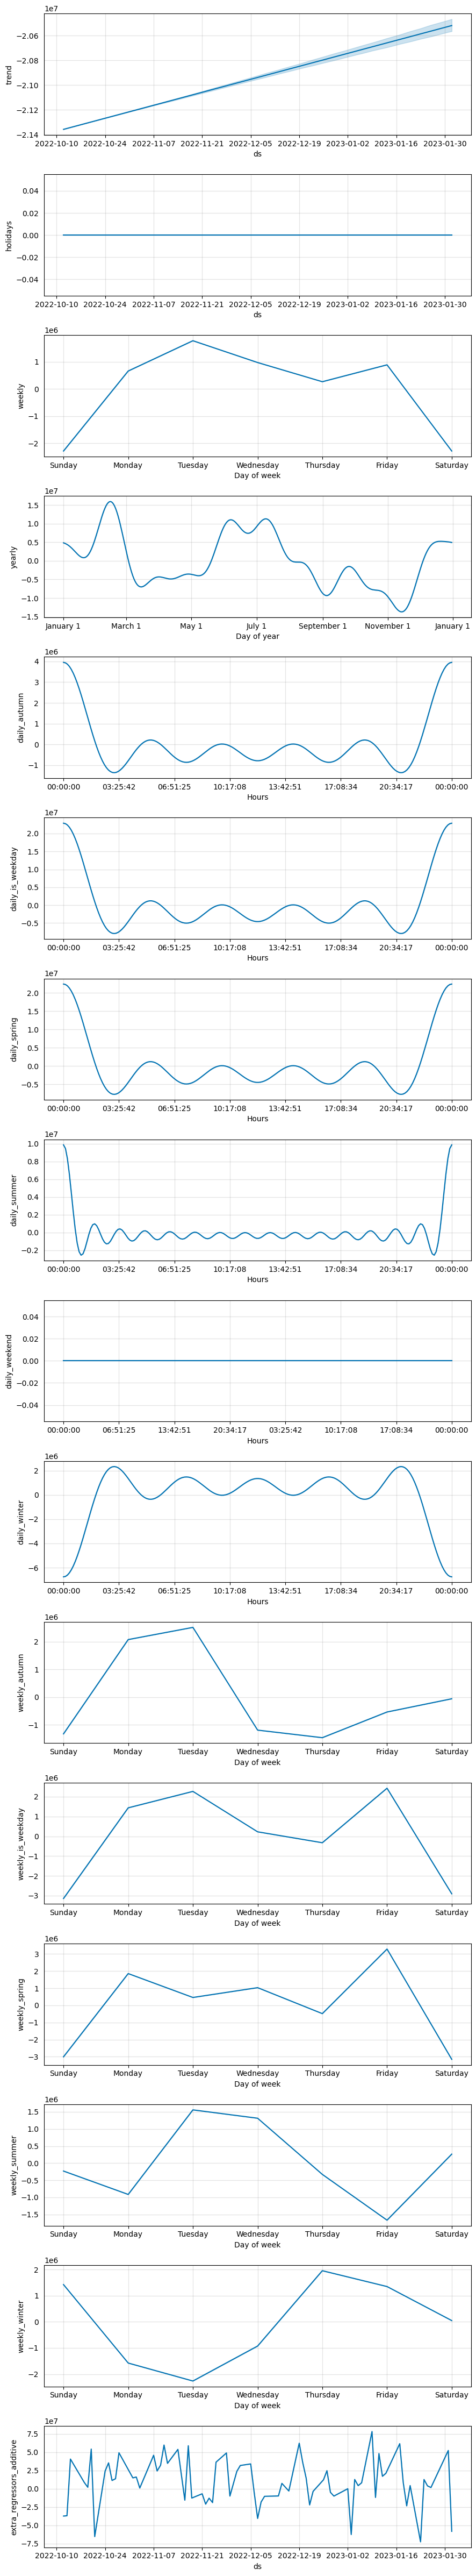

In [67]:
fig = model.plot_components(test_prediction)
plt.show()

**Explanation of 16 plots:**

1. The first plot fact is that the trend is clearly upwards over time

2. The second plot shows that the holidays doesnot effect the model

3. The third plot demonstrates that net cash flow  peaks on Tuesday, and hit bottom on Saturday and Sunday

4. The fourth plot shows that the busiest working period is in February

5. While the net money flow increases at 00:00, it seems to decrease at other hours (daily autumn, daily weekday, daily spring, daily summer)

6. At the daily weekend,  there is no cash flow

7. In daily winter, net cash flow peaks at 3 am and 20:34 

8. Weekly autumn plot demonstrates that net cash flows peak on Tuesday, and hit bottom on Thursday

9.  Net cash flows increase on Friday and decreases on Thursday

10. At weekly summer,  net cash flow peaks on Tuesday

11. At weekly winter, net cash flow increases on Thursday.

12. When we add the regressors to the model,  we can see that net cash flow fluctuated

For performance metrics, we used MAPE. The MAPE value of the forecasted values was calculated with the best value we submitted. 

In [68]:
#best_score=pd.read_csv('/kaggle/input/bestsubmission/lastbestsubmission.csv')

#best_MAPE = mean_absolute_percentage_error(test_prediction['yhat'],best_score['Net Cashflow from Operations'])

#print(f'The best MAPE for the model is {best_MAPE}')

submission.to_csv("/kaggle/working/submission.csv", index=False)

# Conclusion

We utilized various techniques for preprocessing and feature engineering on the data.

We conducted an in-depth analysis and exploration of the data, interpreting each step of the process. 

Finally, we employed the Prophet library to forecast net cash flow. 

This concludes our notebook. We hope you have found it valuable. 

Thank you for your time.